# Task 1 – Dataset Creation and Preprocessing for xG Prediction

This notebook is dedicated to the **creation** and **preprocessing** of structured datasets for the xG analysis task.  
The objective is to build **progressive versions of the dataset**, starting from a minimal shot-only baseline and then gradually adding contextual information such as passes, possessions, and freeze frames. Each stage is versioned separately to ensure reproducibility and to allow the evaluation of the marginal contribution of additional features.


## DS0: Basic Shots Information

The first dataset serves as a **clean baseline focused solely on the shot event**, including only information available **prior to the outcome**. The model inputs are:  

- **`location`** → decomposed into `location_x` and `location_y`, indicating the on-pitch coordinates of the attempt.  
- **`shot_end_location`** → decomposed into `shot_end_x` and `shot_end_y`, capturing where the attempt ended (goal, off target, blocked).  
- **`shot_type`** → categorical, distinguishing penalties, free kicks, open play shots, etc.  
- **`shot_technique`** → categorical, describing execution (e.g., volley, half-volley, normal).  
- **`shot_body_part`** → categorical, specifying right foot, left foot, or head.  
- **`play_pattern`** → categorical, describing the play context (counterattack, set piece, fast break).  
- **`under_pressure`** → binary, indicating defensive pressure at the attempt.  
- **`shot_first_time`** → binary, identifying shots taken without control.  
- **`shot_one_on_one`** → binary, flagging one-on-one situations with the goalkeeper.  
- **`shot_statsbomb_xg`** → continuous, the **target variable**, i.e., StatsBomb’s expected goals estimate.  

Certain variables are excluded to avoid leakage or redundancy:  
- **`shot_outcome`** would reveal the realized result, invalidating the ex-ante probability of xG.  
- **`shot_saved_to_post`** reflects post-shot information, thus unusable as a predictor.  

Finally, temporal variables (**`minute`, `second`, `period`**) are kept to verify if they directly affect the intrinsic probability of conversion.

> **NOTE**  
> The following identifier columns are kept only as **service keys**   to allow merging/enrichment in further datasets.  
> They **MUST NOT** be used as predictive features in the model:
>
> - **`id`** : unique identifier of the event (primary key in StatsBomb events)  
> - **`match_id`** : identifier of the match (needed to retrieve competition/season/gender)  
> - **`team_id`** : identifier of the team performing the event  
> - **`player_id`** : identifier of the player performing the event  
> - **`possession_team_id`** : identifier of the team in possession during the event  

### Basic Info

In [116]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Load the basic shots dataset
shots_df = pd.read_csv("../task1_xg/data/shots_df.csv")

# Columns to keep for DS0
cols_keep = [
    "id", "match_id", "team_id", "player_id", "possession_team_id",
    "minute", "second", "period", 
    "location", "shot_end_location",
    "shot_type", "shot_technique", "shot_body_part", "play_pattern",
    "under_pressure", "shot_first_time", "shot_one_on_one",
    "shot_statsbomb_xg"   # <-- target variable
]

# Build DS0
ds0 = shots_df[cols_keep].copy()

# Basic Info
print("="*50)
print("DATASET DS0 - BASIC INFO")
print("="*50)
print(f"Shape: {ds0.shape[0]} rows, {ds0.shape[1]} columns\n")

print("Column data types:")
print(ds0.dtypes)

# Missing values
print("\n" + "="*50)
print("MISSING VALUES")
print("="*50)
print(ds0.isna().sum())
# Numeric ranges
print("\n" + "="*50)
print("NUMERIC RANGES")
print("="*50)
num_cols = ["minute", "second", "period", "shot_statsbomb_xg"]
for col in num_cols:
    print(f"{col}: min={ds0[col].min()}  max={ds0[col].max()}")

print("\nshot_statsbomb_xg distribution:")
print(ds0["shot_statsbomb_xg"].describe())


# Categorical features
print("\n" + "="*50)
print("CATEGORICAL FEATURES")
print("="*50)
categorical = ["shot_type", "shot_technique", "shot_body_part", "play_pattern"]
for col in categorical:
    print(f"\n--- {col.upper()} ---")
    print("Unique values:", ds0[col].unique())
    print("\nValue counts:")
    print(ds0[col].value_counts(dropna=False))


# Binary flags
print("\n" + "="*50)
print("BINARY FLAGS")
print("="*50)
bin_flags = ["under_pressure", "shot_first_time", "shot_one_on_one"]
for col in bin_flags:
    print(f"\n--- {col.upper()} ---")
    print(ds0[col].value_counts(dropna=False))
    print("Unique values:", ds0[col].unique())

# Event Id Sample
print("\n" + "="*50)
print("EVENT ID SAMPLE")
print("="*50)
print(ds0["id"].sample(3).tolist())

# Verify id uniqueness and NaN
if ds0["id"].is_unique:
    print("\nAll IDs are unique")
if ds0["id"].isna().any():
    print("\nThere are NaN values in 'id' column")

# Location Fields
print("="*50)
print("LOCATION FIELDS (Preview)")
print("="*50)
print("Sample 'location':", ds0["location"].head(3).tolist())
print("Sample 'shot_end_location':", ds0["shot_end_location"].head(3).tolist())


DATASET DS0 - BASIC INFO
Shape: 88023 rows, 18 columns

Column data types:
id                     object
match_id                int64
team_id                 int64
player_id             float64
possession_team_id      int64
minute                  int64
second                  int64
period                  int64
location               object
shot_end_location      object
shot_type              object
shot_technique         object
shot_body_part         object
play_pattern           object
under_pressure         object
shot_first_time        object
shot_one_on_one        object
shot_statsbomb_xg     float64
dtype: object

MISSING VALUES
id                        0
match_id                  0
team_id                   0
player_id                 0
possession_team_id        0
minute                    0
second                    0
period                    0
location                  0
shot_end_location         0
shot_type                 0
shot_technique            0
shot_body_part     

###  Data Situation

The initial inspection of the **DS0 shot dataset** reveals the following:

- Categorical fields (`shot_type`, `shot_technique`, `shot_body_part`, `play_pattern`) are clean and have no missing values

- Binary flags (`under_pressure`, `shot_first_time`, `shot_one_on_one`) contain a high proportion of `NaN`, indicating that missing likely means “False”

- `minute`, `second`, and `period` ranges are valid (e.g., `period` up to 5 accounts for extra-time or penalty shootouts).

- `shot_statsbomb_xg` (our regression target) spans from ~0.0002 to ~0.995, with a realistic distribution (median ~0.055).

- Coordinate fields (`location`, `shot_end_location`) are stored as strings representing lists, needing parsing into numeric `x`, `y` components.

### Cleaning Pipeline for DS0

To prepare **DS0** for modeling, the following transformations are applied:

1. **Rename identifier column**
   - Column: `id`
   - Rename the `id` column to `event_id` to be more clear


2. **Cast categorical columns**  
   - Columns: `shot_type`, `shot_technique`, `shot_body_part`, `play_pattern`  
   - Converted to pandas `category` dtype to optimize memory usage and facilitate encoding

3. **Fill missing binary flags with `False`**  
   - Columns: `under_pressure`, `shot_first_time`, `shot_one_on_one`  
   - Cast to boolean, since in this case Nan indicates a negative condition

4. **Parse coordinate fields**  
   - Convert `location` into numeric columns `loc_x`, `loc_y`
   - Convert `shot_end_location` into `end_shot_x`, `end_shot_y`
   - Drop the original string-based columns afterward

5. **Validate numeric ranges**  
   - Ensure features such as pitch coordinates, seconds, and period values fall within expected limits

6. **Verify missing values**  
   - Confirm dataset completeness before proceeding

In [117]:
import numpy as np
import pandas as pd

# Reload the dataset for reproducibility

# Load the basic shots dataset
shots_df = pd.read_csv("../task1_xg/data/shots_df.csv")

# Columns to keep for DS0
cols_keep = [
    "id", "match_id", "team_id", "player_id", "possession_team_id",
    "minute", "second", "period", 
    "location", "shot_end_location",
    "shot_type", "shot_technique", "shot_body_part", "play_pattern",
    "under_pressure", "shot_first_time", "shot_one_on_one",
    "shot_statsbomb_xg"   # <-- target variable
]

# Build DS0
ds0 = shots_df[cols_keep].copy()

In [118]:
# 1) Rename "id" column into "event_id"
ds0 = ds0.rename(columns={"id": "event_id"})

# 2) Cast categorical columns
# This allows for more efficient memory usage and faster operations
categorical_cols = ["shot_type", "shot_technique", "shot_body_part", "play_pattern"]
ds0[categorical_cols] = ds0[categorical_cols].astype("category")                        

# 3) Fill missing binary flags with False
bin_flags = ["under_pressure", "shot_first_time", "shot_one_on_one"]
for col in bin_flags:
    ds0[col] = ds0[col].fillna(False).astype(bool)              # Binary flags: NaN -> False

# 4) Parse coordinate fields (location and shot_end_location)
def parse_coords_basic(s, n=2):
    """Parse '[x, y]' string into list of floats"""
    vals = s.strip("[]").split(",")   # remove brackets, split by comma
    vals = [float(v) for v in vals]   # convert to floats
    return vals[:n]

# location -> loc_x, loc_y
ds0[["loc_x", "loc_y"]] = ds0["location"].apply(lambda x: pd.Series(parse_coords_basic(x, 2)))

# shot_end_location -> end_shot_x, end_shot_y
ds0[["end_shot_x", "end_shot_y"]] = ds0["shot_end_location"].apply(lambda x: pd.Series(parse_coords_basic(x, 2)))

# Drop original string columns
ds0 = ds0.drop(columns=["location", "shot_end_location"])

# 5) Validate numeric ranges
def check_range(col, min_val, max_val):
    bad = ds0[(ds0[col] < min_val) | (ds0[col] > max_val)]
    if not bad.empty:
        print(f"{col} out of range values found:\n", bad[[col]].head())
    else:
        print(f"{col} within expected range [{min_val}, {max_val}]")

# Example checks
check_range("loc_x", 0, 120)
check_range("loc_y", 0, 80)
check_range("end_shot_x", 0, 120)
check_range("end_shot_y", 0, 80)
check_range("second", 0, 59)
check_range("period", 1, 5)

print("\nDS0 processed - shape:", ds0.shape)


loc_x out of range values found:
        loc_x
4682   120.2
5351   120.4
14663  120.1
61833  120.2
81525  120.1
loc_y within expected range [0, 80]
end_shot_x within expected range [0, 120]
end_shot_y within expected range [0, 80]
second within expected range [0, 59]
period within expected range [1, 5]

DS0 processed - shape: (88023, 20)


> **NOTE**: During the final check, a few `loc_x` values were found slightly above the official pitch limit  These cases occur when an event is registered just beyond the field boundary (e.g. a shot taken or ending out of play).  
It has been decided **not to clip these values**, since the deviation is very small (<1 meter) and may carry meaningful information about the context of the action (e.g. an off-target attempt).   Leaving them as is preserves the fidelity of the raw data while remaining compatible with the modeling stage.


In [119]:
# 6) Verify Missing values in DS0
print("DTYPE SUMMARY")
print(ds0.dtypes)

print("\nMISSING VALUES")
print(ds0.isna().sum())

ds0.head(3)

DTYPE SUMMARY
event_id                object
match_id                 int64
team_id                  int64
player_id              float64
possession_team_id       int64
minute                   int64
second                   int64
period                   int64
shot_type             category
shot_technique        category
shot_body_part        category
play_pattern          category
under_pressure            bool
shot_first_time           bool
shot_one_on_one           bool
shot_statsbomb_xg      float64
loc_x                  float64
loc_y                  float64
end_shot_x             float64
end_shot_y             float64
dtype: object

MISSING VALUES
event_id              0
match_id              0
team_id               0
player_id             0
possession_team_id    0
minute                0
second                0
period                0
shot_type             0
shot_technique        0
shot_body_part        0
play_pattern          0
under_pressure        0
shot_first_time       0


event_id  match_id  team_id  player_id  \
0  c577e730-b9f5-44f2-9257-9e7730c23d7b   3895302      176     8826.0   
1  bbc2c68d-c096-483d-abf4-32c0175a0f55   3895302      904    38004.0   
2  12b5206b-9ed0-4b1e-9ec3-f2028187e09f   3895302      176    51769.0   

   possession_team_id  minute  second  period  shot_type shot_technique  \
0                 176       6      48       1  Open Play         Normal   
1                 904       7      40       1  Open Play         Normal   
2                 176      11       8       1  Open Play         Normal   

  shot_body_part    play_pattern  under_pressure  shot_first_time  \
0     Right Foot  From Free Kick           False             True   
1      Left Foot    Regular Play            True             True   
2      Left Foot  From Free Kick           False             True   

   shot_one_on_one  shot_statsbomb_xg  loc_x  loc_y  end_shot_x  end_shot_y  
0            False           0.056644  100.4   35.1       101.6        35.2  
1            False           0.143381  114.6   33.5       118.1        35.7  
2            False           0.038188  106.2   55.8       113.4        46.8

### Preprocessing Pipeline for DS0 

During preprocessing, the dataset is standardized to ensure **consistency and comparability**:  

1. **Normalization** → Spatial (`loc_x`, `loc_y`, `end_shot_x`, `end_shot_y`) and temporal features (`minute`, `second`) are scaled to `[0,1]` using `MinMaxScaler`
2. **Encoding** → Categorical variables are one-hot encoded into binary indicators
3. **Final structure of DS0** →  
   - **Numerical features**: normalized coordinates, `minute`, `second`, `period`, binary flags, and shot-related continuous features
   - **Categorical features**: one-hot encoded variables
   - **Target**: `shot_statsbomb_xg` (expected goals)

In [120]:
from sklearn.preprocessing import MinMaxScaler

# 1) Normalize numeric features (keep them as float32)
numeric_cols = ["loc_x", "loc_y", "end_shot_x", "end_shot_y", 
              "minute", "second"]


# MinMaxScaler formula:
# X_scaled = (X - X_min) / (X_max - X_min)
scaler = MinMaxScaler()
ds0[numeric_cols] = scaler.fit_transform(ds0[numeric_cols])

print("Numeric ranges after normalization:")
print(ds0[numeric_cols].describe().T)

# 2) One-Hot Encode categorical features (including 'period')
categorical_cols = ["period", "shot_type", "shot_technique", "shot_body_part", "play_pattern"]
ds0 = pd.get_dummies(ds0, columns=categorical_cols)

# 2.1) Remove spaces in column names (replace with underscore)
ds0.columns = ds0.columns.str.replace(" ", "_")

# 3) Final check
print("\nDTYPE SUMMARY AFTER PREPROCESSING")
print(ds0.dtypes)
print("\nDS0 shape:", ds0.shape)

ds0.head(3)


Numeric ranges after normalization:
              count      mean       std  min       25%       50%       75%  \
loc_x       88023.0  0.812739  0.097400  0.0  0.743079  0.828350  0.890365   
loc_y       88023.0  0.495153  0.124037  0.0  0.404015  0.498118  0.585947   
end_shot_x  88023.0  0.917267  0.125201  0.0  0.880374  0.981308  1.000000   
end_shot_y  88023.0  0.499401  0.088085  0.0  0.451815  0.499374  0.546934   
minute      88023.0  0.353498  0.196186  0.0  0.187050  0.352518  0.517986   
second      88023.0  0.499131  0.294107  0.0  0.237288  0.491525  0.745763   

            max  
loc_x       1.0  
loc_y       1.0  
end_shot_x  1.0  
end_shot_y  1.0  
minute      1.0  
second      1.0  

DTYPE SUMMARY AFTER PREPROCESSING
event_id                         object
match_id                          int64
team_id                           int64
player_id                       float64
possession_team_id                int64
minute                          float64
second          

event_id  match_id  team_id  player_id  \
0  c577e730-b9f5-44f2-9257-9e7730c23d7b   3895302      176     8826.0   
1  bbc2c68d-c096-483d-abf4-32c0175a0f55   3895302      904    38004.0   
2  12b5206b-9ed0-4b1e-9ec3-f2028187e09f   3895302      176    51769.0   

   possession_team_id    minute    second  under_pressure  shot_first_time  \
0                 176  0.043165  0.813559           False             True   
1                 904  0.050360  0.677966            True             True   
2                 176  0.079137  0.135593           False             True   

   shot_one_on_one  ...  shot_body_part_Right_Foot  play_pattern_From_Corner  \
0            False  ...                       True                     False   
1            False  ...                      False                     False   
2            False  ...                      False                     False   

   play_pattern_From_Counter  play_pattern_From_Free_Kick  \
0                      False                         True   
1                      False                        False   
2                      False                         True   

   play_pattern_From_Goal_Kick  play_pattern_From_Keeper  \
0                        False                     False   
1                        False                     False   
2                        False                     False   

   play_pattern_From_Kick_Off  play_pattern_From_Throw_In  play_pattern_Other  \
0                       False                       False               False   
1                       False                       False               False   
2                       False                       False               False   

   play_pattern_Regular_Play  
0                      False  
1                       True  
2                      False  

[3 rows x 45 columns]

### Final Step – Target Definition and Save

At this stage, we define the target variable for our models.  
The **expected goals (xG)** value, provided by StatsBomb as `statsbomb_shot_xg`, is renamed to **`target_xg`** for clarity and consistency.  

The final preprocessed dataset is then saved as `DSO.csv` to ensure reproducibility and easy access for model training.


In [121]:
# Rename target column
ds0 = ds0.rename(columns={"shot_statsbomb_xg": "target_xg"})

# Save final dataset
output_path = "../task1_xg/data/DS0.csv"
ds0.to_csv(output_path, index=False)

print(f"Dataset saved successfully as {output_path}")
print("Final shape:", ds0.shape)


Dataset saved successfully as ../task1_xg/data/DS0.csv
Final shape: (88023, 45)


## DS1: Feature Refinement and Enrichment with Competition Gender

The training of the basic model **DS0** highlighted that not all categorical features contribute substantially to predictive performance. For example, `shot_type_Penalty` emerged as one of the most important features, whereas `shot_type_Kick_Off` or `shot_type_Corner` carried almost no signal. Similarly, several variables related to game period or temporal context did not improve the model, and some play pattern indicators overlapped with the information already captured by shot type.  

To address this, DS1 introduces five main modifications.  

1. **Introduction of `shot_from_set_piece`** : the original `shot_type_*` features were replaced by a single binary variable: 

   - `shot_from_set_piece = 1` → Penalty, Free Kick, Corner, Kick Off  

   - `shot_from_set_piece = 0` → Open Play 

   This preserves the distinction between open play and set-piece shots while avoiding redundancy across multiple one-hot columns.  

2. **Aggregation of `shot_technique`** : The original one-hot encoded `shot_technique_*` variables were too sparse, with many categories carrying little predictive signal. To reduce noise and improve interpretability, all techniques were grouped into three **mutually exclusive binary variables**:  

   - `shot_technique_Normal` → conventional techniques such as standard or controlled shots (same as before)  

   - `shot_technique_Aerial` → techniques requiring the ball to be in the air, e.g. volleys, half-volleys, diving headers, overhead kicks  

   - `shot_technique_Special` → non-standard or trick-based techniques such as backheel or lob  

   This aggregation increases the statistical relevance of each feature while preserving the main tactical distinctions in shooting techniques.  

3. **Introduction of Spatial Features**: To better capture the geometry of the shot situation, two continuous features were added:  

   - `distance_to_goal`: the Euclidean distance from the shot location to the center of the goal.  

   - `angle_to_goal`: the angle between the lines from the shot location to the two goalposts, capturing how “open” the goal appears from the shooter’s perspective.  

4. **Feature Reduction**  
   Redundant or uninformative variables were modified/removed:

   - `period_*` features were replaced with three mutually exclusive binary variables (`Regular_Time`, `Extra_Time`, `Penalty_Shootout`), providing a compact and interpretable representation of the match context.  

   - The `play_pattern_*` variables were largely redundant once the `shot_from_set_piece` indicator was introduced, since most of them directly overlap with the definition of a set piece. To retain only the meaningful information, these columns were consolidated into three mutually exclusive binary variables representing the variable `play_context`:  

      - `play_context_Regular_Play` → 1 if the possession started in open play  

      - `play_context_Counter` → 1 if the possession started from a counter-attack  

      - `play_context_Set_Piece` → 1 if the possession started from a structured set piece  

      This design keeps the dataset compact while still preserving the distinction between regular play, counter-attacks, and structured set-piece situations.  

5. **Addition of `gender`**: A new categorical variable `gender` was introduced to allow comparisons between male and female competitions and to test whether the xG model behaves differently across contexts.  

6. **Introduction of Shooter Role**:  
   To incorporate contextual information about the player, a new categorical variable was added to represent the **role of the shooter** at the moment of the shot. Player positions from the lineup data were mapped into three **macro-categories**:  

   - `Shooter_DEF` → Defender  
   - `Shooter_MID` → Midfielder  
   - `Shooter_FWD` → Forward  

   This feature captures broad tactical responsibilities and typical shooting positions, while avoiding overfitting to specific player or team identities.  

### 1) Introduction of `shot_from_set_piece`

The `shot_type_*` columns are one-hot encoded, with a value of `1` for the actual shot type and `0` otherwise.  
The new variable `shot_from_set_piece` is obtained by taking the row-wise maximum across the set-piece columns (`Corner`, `Free Kick`, `Kick Off`, `Penalty`). This returns `1` if the shot comes from a set piece and `0` otherwise, providing a compact binary representation.

In [122]:
import pandas as pd

# Load DS0
ds0 = pd.read_csv("../task1_xg/data/DS0.csv")

# Print all the columns that starts with "shot_type_"
print(ds0.columns[ds0.columns.str.startswith("shot_type_")])

Index(['shot_type_Corner', 'shot_type_Free_Kick', 'shot_type_Kick_Off',
       'shot_type_Open_Play', 'shot_type_Penalty'],
      dtype='object')


In [123]:
# Define set-piece columns
set_piece_cols = [
    "shot_type_Corner",
    "shot_type_Free_Kick",
    "shot_type_Kick_Off",
    "shot_type_Penalty"
]

# Create a copy of the original DataFrame
ds1 = ds0.copy()

# Create a new binary column: 1 if the shot comes from a set piece, 0 otherwise
ds1["shot_from_set_piece"] = ds1[set_piece_cols].max(axis=1)

# Drop the original one-hot columns including "Open_Play"
ds1 = ds1.drop(columns=set_piece_cols + ["shot_type_Open_Play"])


In [124]:
# Validation
print("DS0 Original Features")
print(f"Open play: {ds0['shot_type_Open_Play'].sum()}")
print(f"Set pieces: {ds0[set_piece_cols].sum(axis=1).sum()}")

count_ds1 = ds1["shot_from_set_piece"].value_counts()

print("\nDS1 Shot From Set Piece")
print(f"Open play (0): {count_ds1[0]}")
print(f"Set pieces (1): {count_ds1[1]}")


DS0 Original Features
Open play: 82402
Set pieces: 5621

DS1 Shot From Set Piece
Open play (0): 82402
Set pieces (1): 5621


### 2) Aggregation of `shot_technique` into Normal, Aerial, and Special


In [125]:
# Print all shot_technique columns from DS0
print(ds0.columns[ds0.columns.str.startswith("shot_technique_")])

Index(['shot_technique_Backheel', 'shot_technique_Diving_Header',
       'shot_technique_Half_Volley', 'shot_technique_Lob',
       'shot_technique_Normal', 'shot_technique_Overhead_Kick',
       'shot_technique_Volley'],
      dtype='object')


In [126]:
# Create new shot technique columns

# shot_technique_Normal remains the same

ds1["shot_technique_Aerial"] = ds1[
    ["shot_technique_Half_Volley", "shot_technique_Volley", "shot_technique_Diving_Header"]
].max(axis=1)

ds1["shot_technique_Special"] = ds1[
    ["shot_technique_Lob", 
     "shot_technique_Overhead_Kick",
     "shot_technique_Backheel"]
].max(axis=1)

# Remove original columns
cols_to_drop = [
    "shot_technique_Diving_Header",
    "shot_technique_Volley", "shot_technique_Half_Volley",
    "shot_technique_Lob", "shot_technique_Overhead_Kick", "shot_technique_Backheel"
]
ds1 = ds1.drop(columns=cols_to_drop)


In [127]:
# Check mapping between DS0 one-hot and DS1 aggregated shot_technique features

# Sum original DS0 one-hot columns
ds0_sum = ds0.filter(like="shot_technique").sum()

# Grouped checks
print("Check Normal")
print("DS0:", ds0_sum.get("shot_technique_Normal", 0))
print("DS1:", ds1["shot_technique_Normal"].sum(), "\n")

print("Check Aerial")
ds0_aerial = (
    ds0_sum.get("shot_technique_Volley", 0)
    + ds0_sum.get("shot_technique_Half_Volley", 0)
    + ds0_sum.get("shot_technique_Diving_Header", 0)
)
print("DS0:", ds0_aerial)
print("DS1:", ds1["shot_technique_Aerial"].sum(), "\n")

print("Check Special")
ds0_special = (
    ds0_sum.get("shot_technique_Backheel", 0)
    + ds0_sum.get("shot_technique_Lob", 0)
    + ds0_sum.get("shot_technique_Overhead_Kick", 0)
)
print("DS0:", ds0_special)
print("DS1:", ds1["shot_technique_Special"].sum(), "\n")

# Global check
print("Total")
print("DS0:", ds0_sum.sum())
print("DS1:", ds1[["shot_technique_Normal", "shot_technique_Aerial", "shot_technique_Special"]].sum().sum())


Check Normal
DS0: 68665
DS1: 68665 

Check Aerial
DS0: 17680
DS1: 17680 

Check Special
DS0: 1678
DS1: 1678 

Total
DS0: 88023
DS1: 88023


### 3) Introduction of Shot Distance and Shot Angle

The dataset is enriched with two engineered features derived from `loc_x`, `loc_y`:

- **Shot Distance**: the Euclidean distance between the shot location and the center of the goal (x=120, y=40). This feature captures how far the shooter was from the target. 

- **Shot Angle**: the angle under which the shooter sees the two goalposts  (left post at x=120, y=36; right post at x=120, y=44). This represents the scoring angle. In general, wider angles correspond to higher scoring  probabilities.

In [128]:
import numpy as np

# Pitch and goal dimensions in StatsBomb coordinates (120x80)
PITCH_X = 120
PITCH_Y = 80
GOAL_X = 120
GOAL_Y_TOP = 44
GOAL_Y_BOTTOM = 36
GOAL_CENTER_Y = 40

def to_pitch_coords(x, y):
    """
    Convert normalized coordinates (x,y) from [0,1] to StatsBomb pitch units
    
    Parameters:
        x (float): Normalized x position (0 = own goal line, 1 = opponent's goal line)
        y (float): Normalized y position (0 = bottom touchline, 1 = top touchline)

    Returns
        (x_m, y_m): Coordinates in StatsBomb pitch units (x in [0,120], y in [0,80])
    """
    return x * PITCH_X, y * PITCH_Y


def compute_distance(x, y):
    """
    Compute the Euclidean distance between a location (x,y) and the center of the opponent's goal
    
    Formula:
        d = sqrt((GOAL_X - x_m)^2 + (GOAL_CENTER_Y - y_m)^2)
    
    Parameters:
    x (float): Normalized x position in [0,1]
    y (float): Normalized y position in [0,1]

    Returns:
    distance (float): Distance to the goal center, measured in pitch units
    """
    x_m, y_m = to_pitch_coords(x, y)
    return np.sqrt((GOAL_X - x_m) ** 2 + (GOAL_CENTER_Y - y_m) ** 2)


def compute_angle(x, y):
    """
    Compute the visible shooting angle of the goal from a given location (x,y)
    From the player's location, two lines are computed: one to the top post and one to the bottom post
    The difference in their angles (w.r.t the x-axis) gives the apparent opening angle of the goal
    If the player is on or beyond the goal line (x >= GOAL_X), the angle is set to 0
    
    Formula:
        angle = | atan2(GOAL_Y_TOP - y_m, GOAL_X - x_m) - atan2(GOAL_Y_BOTTOM - y_m, GOAL_X - x_m) |
    
    Parameters:
        x (float): Normalized x position in [0,1]
        y (float): Normalized y position in [0,1]

    Returns:
        angle (float): Visible angle of the goal in radians (range: [0, π])
    """
    x_m, y_m = to_pitch_coords(x, y)
    dx = GOAL_X - x_m
    if dx <= 0:  # shot beyond/at goal line
        return 0.0
    angle_top = np.arctan2((GOAL_Y_TOP - y_m), dx)
    angle_bottom = np.arctan2((GOAL_Y_BOTTOM - y_m), dx)
    return abs(angle_top - angle_bottom)


# Add new features to the dataset
ds1["distance_to_goal"] = ds1.apply(lambda row: compute_distance(row["loc_x"], row["loc_y"]), axis=1)
ds1["angle_to_goal"] = ds1.apply(lambda row: compute_angle(row["loc_x"], row["loc_y"]), axis=1)

# Show results
print("New features: distance to goal & angle to goal")
print(ds1[["loc_x", "loc_y", "distance_to_goal", "angle_to_goal"]].head(10))


New features: distance to goal & angle to goal
      loc_x     loc_y  distance_to_goal  angle_to_goal
0  0.777409  0.436637         27.187689       0.287312
1  0.934662  0.416562         10.297086       0.608511
2  0.841639  0.696361         24.655548       0.251412
3  0.926910  0.590966         11.396721       0.552183
4  0.653378  0.529486         41.661516       0.191137
5  0.885936  0.405270         15.645631       0.446399
6  0.832780  0.562108         20.672434       0.372078
7  0.861573  0.498118         16.611978       0.472567
8  0.789590  0.592221         26.304952       0.290382
9  0.953488  0.573400          8.101395       0.732613


In [129]:
# Min and Max values for distance and angle
print("Min and Max values for distance to goal:")
print(ds1["distance_to_goal"].min(), ds1["distance_to_goal"].max())

print("\nMin and Max values for angle to goal:")
print(ds1["angle_to_goal"].min(), ds1["angle_to_goal"].max())

Min and Max values for distance to goal:
0.8638737214163487 121.9726904292471

Min and Max values for angle to goal:
0.0 2.806272741401223


> **NOTE**: `distance_to_goal` is the Euclidean distance from shot location `(x,y)` to the goal center `(120,40)`.  
> Minimum is `0` (at goal center).  
> Maximum exceeds `120` since distance is diagonal; e.g., from `(0,0)` → ~126.5.  
> In this dataset: ~0.86–121.97 m.  

In [130]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler formula:
# X_scaled = (X - X_min) / (X_max - X_min)

# Normalize distance_to_goal and angle_to_goal with min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
ds1[["distance_to_goal", "angle_to_goal"]] = scaler.fit_transform(
    ds1[["distance_to_goal", "angle_to_goal"]]
)

# Validation
print("Min and Max values for distance to goal:")
print(ds1["distance_to_goal"].min().round(1), ds1["distance_to_goal"].max().round(1))

print("\nMin and Max values for angle to goal:")
print(ds1["angle_to_goal"].min().round(1), ds1["angle_to_goal"].max().round(1))


Min and Max values for distance to goal:
0.0 1.0

Min and Max values for angle to goal:
0.0 1.0


### 4) Features Reduction

In [131]:
# Print all the columns that starts with "period_" or "play_pattern_"
print(ds1.columns[ds1.columns.str.startswith("period_")])
print(ds1.columns[ds1.columns.str.startswith("play_pattern_")])

Index(['period_1', 'period_2', 'period_3', 'period_4', 'period_5'], dtype='object')
Index(['play_pattern_From_Corner', 'play_pattern_From_Counter',
       'play_pattern_From_Free_Kick', 'play_pattern_From_Goal_Kick',
       'play_pattern_From_Keeper', 'play_pattern_From_Kick_Off',
       'play_pattern_From_Throw_In', 'play_pattern_Other',
       'play_pattern_Regular_Play'],
      dtype='object')


In [132]:
# Replace period_* with 3 mutually exclusive binary variables
ds1["regular_Time"] = (ds1[["period_1", "period_2"]].max(axis=1))
ds1["extra_Time"] = (ds1[["period_3", "period_4"]].max(axis=1))
ds1["penalty_Shootout"] = ds1["period_5"]

# Drop old period_* columns
period_cols = [col for col in ds1.columns if col.startswith("period_")]
ds1 = ds1.drop(columns=period_cols, errors="ignore")

# Consolidate play_pattern_* into play_context_*
ds1["play_context_Regular_Play"] = ds1[["play_pattern_Regular_Play", "play_pattern_From_Keeper"]].max(axis=1)

ds1["play_context_Counter"] = ds1["play_pattern_From_Counter"]

ds1["play_context_Set_Piece"] = ds1[[
    "play_pattern_From_Corner",
    "play_pattern_From_Free_Kick",
    "play_pattern_From_Goal_Kick",
    "play_pattern_From_Kick_Off",
    "play_pattern_From_Throw_In",
    "play_pattern_Other"
]].max(axis=1)

# Drop original play_pattern_* columns
play_pattern_cols = [col for col in ds1.columns if col.startswith("play_pattern_")]
ds1 = ds1.drop(columns=play_pattern_cols, errors="ignore")

In [133]:
# Validation

# Period Features
check_regular = (ds0[["period_1", "period_2"]].max(axis=1))
check_extra   = (ds0[["period_3", "period_4"]].max(axis=1))
check_penalty = ds0["period_5"]

assert ds1["regular_Time"].equals(check_regular), "Regular_Time mismatch"
assert ds1["extra_Time"].equals(check_extra), "Extra_Time mismatch"
assert ds1["penalty_Shootout"].equals(check_penalty), "Penalty_Shootout mismatch"

# Play Patterns
check_regular_play = ds0[["play_pattern_Regular_Play", "play_pattern_From_Keeper"]].max(axis=1)
check_counter      = ds0["play_pattern_From_Counter"]
check_set_piece    = ds0[[
    "play_pattern_From_Corner",
    "play_pattern_From_Free_Kick",
    "play_pattern_From_Goal_Kick",
    "play_pattern_From_Kick_Off",
    "play_pattern_From_Throw_In",
    "play_pattern_Other"
]].max(axis=1)

assert ds1["play_context_Regular_Play"].equals(check_regular_play), "play_context_Regular_Play mismatch"
assert ds1["play_context_Counter"].equals(check_counter), "play_context_Counter mismatch"
assert ds1["play_context_Set_Piece"].equals(check_set_piece), "play_context_Set_Piece mismatch"

print("All validations passed successfully")


All validations passed successfully


### 5) Enrichment with competition gender

Including the `gender` category enables the model to capture systematic differences between men’s and women’s competitions—such as tactical patterns, play pace, or physical dynamics—that may influence shot outcomes and expected goals (xG).

The workflow operates as follows:

1. DS0 already includes `match_id` for every shot event.
2. For each competition-season pair, retrieve match data via `sb.matches()`. Each returned match record includes `match_id`, as well as text fields `competition` and `season`.
3. The `competition` field in the `matches` output appears in a format like `"Spain - La Liga"`. To align it with the competition names in `sb.competitions()` (which uses `"competition_name"`), the code splits the string at the first dash (`-`) and uses the second part (e.g. `"La Liga"`). Then it's stripped and renamed to `"competition_name"`.
4. After standardizing the competition and season names, merge with the `sb.competitions()` metadata (which includes `competition_gender`) using `[competition_name, season_name]` as keys.
5. The result of this join yields a mapping `match_id → gender`, which is then merged back into DS0 to produce **DS1**, containing the additional column `gender`.

As before, `match_id` is used solely as an **enrichment key** and is not included as a predictive feature in the model.


In [134]:
import pandas as pd
from statsbombpy import sb

# Create a copy of ds1 to work with
ds1_copy = ds1.copy()

# Retrieve all competitions data, keeping only the relevant columns
competitions = sb.competitions()
competitions = competitions[[
    "competition_id", 
    "season_id", 
    "competition_name", 
    "season_name", 
    "competition_gender"
]]

# Extract the set of unique match_ids from DS1
unique_match_ids = set(ds1_copy["match_id"].unique())

# Container for match metadata
match_data = []

# Iterate over each competition-season pair
for _, row in competitions.iterrows():
    comp_id = row["competition_id"]
    season_id = row["season_id"]

    try:
        # Retrieve all matches metadata for this competition-season
        matches = sb.matches(competition_id=comp_id, season_id=season_id)

        # Normalize competition name (remove "country -")
        matches["competition"] = matches["competition"].str.split("-").str[1].str.strip()

        # Rename columns to align with competitions DataFrame
        matches = matches.rename(columns={
            "competition": "competition_name",
            "season": "season_name",
        })

        # Keep only relevant matches
        matches = matches[matches["match_id"].isin(unique_match_ids)]

        if not matches.empty:
            # Merge with competitions metadata to attach the gender
            matches = matches.merge(
                competitions,
                on=["competition_name", "season_name"],
                how="left"
            )
            match_data.append(matches)
    except Exception as e:
        print(f"Error fetching comp={comp_id}, season={season_id}: {e}")

# Concatenate all collected matches into a single DataFrame
df_matches = pd.concat(match_data, ignore_index=True)

# Keep only match_id and gender, removing duplicates
df_matches = df_matches[["match_id", "competition_gender"]].drop_duplicates()

# Rename column for clarity
df_matches = df_matches.rename(columns={"competition_gender": "gender"})

# Update the original ds1
ds1 = ds1_copy.merge(df_matches, on="match_id", how="left")

print("DS1 shape:", ds1.shape)
print(ds1[["match_id", "gender"]].head())


DS1 shape: (88023, 32)
   match_id gender
0   3895302   male
1   3895302   male
2   3895302   male
3   3895302   male
4   3895302   male


In [135]:
# Verify if there are NaN values in gender
missing_gender = ds1["gender"].isna().sum()
print(f"Number of NaN values in gender: {missing_gender}")

# Show rows with missing gender (if any)
if missing_gender > 0:
    display(ds1[ds1["gender"].isna()])


Number of NaN values in gender: 0


#### Normalization of Gender Column

To facilitate its use in **predictive models**, the categorical variable `gender` (with values `"male"` or `"female"`) is transformed into a **binary numerical feature**:

- `"male"` --> **1**  
- `"female"` -->  **0**

The new column is stored as `gender_binary

In [136]:
# Normalize gender column to binary 0/1
# Let's map Male → 1, Female → 0
ds1["gender_binary"] = ds1["gender"].str.lower().map({
    "male": 1,
    "female": 0
})

ds1.drop(columns=["gender"], inplace=True)

# Verify the distribution
print(ds1["gender_binary"].value_counts(dropna=False))

gender_binary
1    73874
0    14149
Name: count, dtype: int64


### 6) Integrating Player Role Information into Shot Data

#### Building the Roles Dataset

All possible **player roles** available in the StatsBomb open data are first collected by iterating through competitions, matches, and Starting XI events into the file `unique_roles.csv`.  

In [137]:
from statsbombpy import sb
import pandas as pd
from tqdm import tqdm
import warnings
import os

warnings.filterwarnings("ignore")

# Path where the roles file will be saved
roles_file = "../task1_xg/data/unique_roles.csv"

# Check if the file already exists
if os.path.exists(roles_file):
    print(f"File '{roles_file}' already exists. Skipping extraction.")
    roles_df = pd.read_csv(roles_file)
else:
    # Container for unique player roles
    all_roles = set()
    skipped_matches = 0

    # Load all available competitions from StatsBomb and sort them by season
    comps = sb.competitions().sort_values(by="season_name")

    # Iterate over competitions with a progress bar
    for _, comp in tqdm(comps.iterrows(), total=len(comps), desc="Competitions"):
        comp_id = comp["competition_id"]
        season_id = comp["season_id"]

        try:
            # Load all matches for the given competition and season
            matches = sb.matches(competition_id=comp_id, season_id=season_id)
        except Exception as e:
            print(f"Failed to load matches for {comp['competition_name']} - {comp['season_name']}: {e}")
            continue

        # Iterate over all matches (no progress bar to keep it lighter)
        for match_id in matches["match_id"].unique():
            try:
                # Load event data for the match
                events = sb.events(match_id=match_id)

                # Filter Starting XI events
                starting_xi = events[events["type"] == "Starting XI"]

                # For each Starting XI (one per team), extract player roles
                for i in range(len(starting_xi)):
                    lineup = starting_xi.iloc[i]["tactics"].get("lineup", [])
                    for player in lineup:
                        role = player.get("position", {}).get("name")
                        if role:
                            all_roles.add(role)

            except Exception:
                # Count matches skipped due to errors
                skipped_matches += 1
                continue

    # Save all unique roles into a DataFrame
    roles_df = pd.DataFrame(sorted(all_roles), columns=["role"])

    print(f"\nFile '{roles_file}' saved with", len(roles_df), "unique roles.")
    print("Total skipped matches due to errors:", skipped_matches)


File '../task1_xg/data/unique_roles.csv' already exists. Skipping extraction.


Subsequently, these detailed roles are mapped into broader macro-categories (Goalkeeper, Defender, Midfielder, Forward).  

In [138]:
# Mapping detailed roles into macro categories
role_to_macro = {
    "Goalkeeper": "GK",
    "Left Back": "DEF", "Left Center Back": "DEF", "Center Back": "DEF",
    "Right Center Back": "DEF", "Right Back": "DEF",
    "Left Wing Back": "DEF", "Right Wing Back": "DEF",

    "Left Defensive Midfield": "MID", "Left Center Midfield": "MID",
    "Center Defensive Midfield": "MID", "Center Midfield": "MID",
    "Center Attacking Midfield": "MID", "Right Center Midfield": "MID",
    "Right Defensive Midfield": "MID", "Left Midfield": "MID",
    "Right Midfield": "MID", "Left Attacking Midfield": "MID",
    "Right Attacking Midfield": "MID",

    "Left Wing": "FWD", "Right Wing": "FWD",
    "Left Center Forward": "FWD", "Center Forward": "FWD",
    "Right Center Forward": "FWD", "Secondary Striker": "FWD"
}

# Add macro_role column
roles_df["macro_role"] = roles_df["role"].map(role_to_macro)

# Save updated roles file
roles_df.to_csv(roles_file, index=False)
print(f"Updated file saved to '{roles_file}' with macro roles included.")

Updated file saved to '../task1_xg/data/unique_roles.csv' with macro roles included.


#### Macro Roles Assignment to DS1

Each player can be assigned multiple roles during the course of a match. Since a player may switch positions at different times, it is not sufficient to assign a single static role to all their actions. Instead, the role at the **exact moment of the shot** must be identified.  

To achieve this, the temporal intervals associated with each role are compared with the minute and second of the shot. The player’s active role is then extracted by verifying which role assignment was valid at that specific minute and second of the match. This ensures that the dataset reflects the tactical context of the shot more accurately, linking each attempt not only to the player but also to the position they were occupying at that point in time.  

> **Note on edge cases**:  
> - If no role matches the shot minute (e.g., due to missing or incomplete time intervals), the player’s **initial role** is assigned  
> - If the lineup contains no role information for the player at all, the process stops to avoid introducing misleading data

In [139]:
from statsbombpy import sb

# Test: pick a random match (here we take the first from World Cup 2018)
matches = sb.matches(competition_id=43, season_id=3)  
match_id = matches.iloc[0]["match_id"]

# Load lineups for the match
lineups = sb.lineups(match_id)

# Select one team (first in the dictionary)
team = list(lineups.keys())[0]
players_df = lineups[team]

# Pick one player just to check
player_row = players_df.iloc[0]

print("TEST: Player info from lineups")
print("Player ID:", player_row["player_id"])
print("Player Name:", player_row["player_name"])
print("Positions recorded:")

# The 'positions' column is a list of dicts, one per role/time interval
for pos in player_row["positions"]:
    print(f" - {pos['position']} (from {pos['from']} to {pos['to']})")


TEST: Player info from lineups
Player ID: 3094
Player Name: Bamidele Alli
Positions recorded:
 - Left Attacking Midfield (from 00:00 to 48:20)
 - Left Attacking Midfield (from 49:38 to 80:01)


In [140]:
import pandas as pd
from statsbombpy import sb
from tqdm import tqdm

def time_to_minutes(t):
    """Convert lineup time string (e.g., '45:00') into minutes (float)."""
    if t is None or t == "":
        return float("inf")   # if "to" is None or empty, role lasts until the end of the match
    if isinstance(t, (int, float)):
        return float(t)
    if isinstance(t, str) and ":" in t:
        mm, ss = t.split(":")
        return int(mm) + int(ss) / 60.0
    return float(t)


# Cache to avoid downloading the same lineup multiple times
lineups_cache = {}
roles_data = []

# Iterate over all matches in the dataset
for match_id in tqdm(ds1["match_id"].unique(), desc="Downloading lineups"):
    if match_id in lineups_cache:
        lineups = lineups_cache[match_id]
    else:
        try:
            lineups = sb.lineups(match_id)
            lineups_cache[match_id] = lineups
        except Exception:
            # Some matches may not have a lineup available
            continue

    # Build a dictionary {player_id: list of positions (with from/to times)}
    match_roles = {}
    for team, players in lineups.items():
        for _, row in players.iterrows():
            match_roles[row["player_id"]] = row["positions"]

    # For each shot in this match, find the role of the shooter
    match_shots = ds1[ds1["match_id"] == match_id]
    for _, shot in match_shots.iterrows():
        pid = shot["player_id"]
        minute = shot["minute"]
        role_at_shot = None

        # Case 1: player has positions available in the minute of the shot
        if pid in match_roles and isinstance(match_roles[pid], list) and len(match_roles[pid]) > 0:
            # First, try to find the role valid at the shot's minute
            for pos in match_roles[pid]:
                start = time_to_minutes(pos["from"])
                end = time_to_minutes(pos["to"])
                if start <= minute <= end:
                    role_at_shot = pos["position"]
                    break

            # Case 2: if no role matches the shot minute, use the initial role
            if role_at_shot is None:
                role_at_shot = match_roles[pid][0]["position"]

        # Case 3: player has no role information in the lineup
        else:
            raise SystemExit("Stopped: player without any role information in lineup.")

        # Store event_id → role mapping
        roles_data.append({
            "event_id": shot["event_id"],
            "role": role_at_shot
        })

# Merge the role information back into ds1
roles_df = pd.DataFrame(roles_data)
ds1 = ds1.merge(roles_df, on="event_id", how="left")

# Keep only original ds1 columns + new role column
cols_to_keep = list(ds1.columns)
ds1 = ds1[cols_to_keep].copy()

# Load mapping role → macro_role
unique_roles = pd.read_csv("../task1_xg/data/unique_roles.csv")

# Add macro_role to ds1
ds1 = ds1.merge(unique_roles[["role", "macro_role"]], on="role", how="left")

# Drop detailed role column, keep only macro_role
ds1 = ds1.drop(columns=["role"])


In [141]:
# Rename macro_role -> role
ds1 = ds1.rename(columns={"macro_role": "role"})

# Verify role distribution
print("Role distribution:")
print(ds1["role"].value_counts(dropna=False))

# Check if all shots have a role assigned
missing_roles = ds1[ds1["role"].isna()]
if missing_roles.empty:
    print("\nAll shots have a role assigned to the shooter.")
else:
    print(f"\nFound {len(missing_roles)} shots without an assigned role.")
    print("Example rows:")
    print(missing_roles.head())

Role distribution:
role
FWD    41251
MID    32243
DEF    14512
GK        17
Name: count, dtype: int64

All shots have a role assigned to the shooter.


#### One-hot encoding of player roles

The column containing the player’s role is categorical and must be converted into a numerical format to be used by machine learning models.  
Instead of using **label encoding**, which assigns arbitrary integer values to categories and may incorrectly introduce an ordinal relationship, **one-hot encoding** is applied.  

This transformation creates one binary column for each possible role (Goalkeeper, Defender, Midfielder, Forward). For each shot, exactly one of these columns takes the value 1, while the others are set to 0.   


In [142]:
import pandas as pd

# One-hot encode the 'role' column
ds1 = pd.get_dummies(ds1, columns=["role"], prefix="role")

# Quick check
print("DS1 with one-hot encoded roles:")
print(ds1.filter(like="role_").head())

# Verify total count matches the number of shots
print("\nNumber of shots (rows):", len(ds1))
print("Number of rows with at least one role assigned:", (ds1.filter(like="role_").sum(axis=1) == 1).sum())


DS1 with one-hot encoded roles:
   role_DEF  role_FWD  role_GK  role_MID
0     False     False    False      True
1      True     False    False     False
2      True     False    False     False
3      True     False    False     False
4     False     False    False      True

Number of shots (rows): 88023
Number of rows with at least one role assigned: 88023


### Final Step – Save the DS1 Dataset

The final dataset is then saved as `DS1.csv` to ensure reproducibility and easy access for model training.


In [143]:
# Final checks
ds1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88023 entries, 0 to 88022
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   event_id                   88023 non-null  object 
 1   match_id                   88023 non-null  int64  
 2   team_id                    88023 non-null  int64  
 3   player_id                  88023 non-null  float64
 4   possession_team_id         88023 non-null  int64  
 5   minute                     88023 non-null  float64
 6   second                     88023 non-null  float64
 7   under_pressure             88023 non-null  bool   
 8   shot_first_time            88023 non-null  bool   
 9   shot_one_on_one            88023 non-null  bool   
 10  target_xg                  88023 non-null  float64
 11  loc_x                      88023 non-null  float64
 12  loc_y                      88023 non-null  float64
 13  end_shot_x                 88023 non-null  flo

In [ ]:
# Save DS1 to disk
ds1.to_csv("../task1_xg/data/DS1.csv", index=False)

## DS2: Incorporating Freeze-Frame Features

Each shot in the StatsBomb dataset (after verifying that no NaN elements are present) contains a *freeze frame*: a snapshot that records the positions of **all players on the pitch** at the exact moment the shot is taken, including the goalkeeper.  

This snapshot provides valuable opportunities for feature engineering, for example:  

- **Number of players between shooter and goal**  
  A discrete count that reflects the defensive density directly obstructing the shooting line.  

- **Distance to the closest defender**  
  A continuous feature that captures the intensity of immediate defensive pressure on the shooter.  

- **Goalkeeper positioning**  
  Features such as the goalkeeper’s x/y coordinates or their distance to the shooter, which directly influence the effective shooting space.  

- **Free projection of the goal**  
  An advanced feature estimating the proportion of the goal area that remains uncovered, by projecting the goalkeeper’s position relative to the posts into the shooter’s field of view.  

Altogether, these features encode the **spatial and tactical context** of a shot, going well beyond simple attributes like location or body part. They have been shown to significantly improve the predictive power of xG models.  

### Analysis of Freeze Frames

In [22]:
import pandas as pd

# Load shots data
shots = pd.read_csv("../task1_xg/data/shots_df.csv")

In [23]:
import ast
import json

# Extract the freeze frame string for a given shot (first shot)
ff_str = shots.loc[0, "shot_freeze_frame"]

# Convert the string into a list of dicts
ff_obj = ast.literal_eval(ff_str)

# Pretty print the freeze frame as JSON
print(json.dumps(ff_obj, indent=2))


[
  {
    "location": [
      101.9,
      35.1
    ],
    "player": {
      "id": 3500,
      "name": "Granit Xhaka"
    },
    "position": {
      "id": 9,
      "name": "Right Defensive Midfield"
    },
    "teammate": false
  },
  {
    "location": [
      107.2,
      38.1
    ],
    "player": {
      "id": 30606,
      "name": "Edmond Fay\u00e7al Tapsoba"
    },
    "position": {
      "id": 5,
      "name": "Left Center Back"
    },
    "teammate": false
  },
  {
    "location": [
      112.9,
      42.4
    ],
    "player": {
      "id": 38004,
      "name": "Piero Mart\u00edn Hincapi\u00e9 Reyna"
    },
    "position": {
      "id": 8,
      "name": "Left Wing Back"
    },
    "teammate": false
  },
  {
    "location": [
      110.4,
      29.4
    ],
    "player": {
      "id": 8221,
      "name": "Jonathan Tah"
    },
    "position": {
      "id": 4,
      "name": "Center Back"
    },
    "teammate": false
  },
  {
    "location": [
      92.1,
      29.0
    ],
    "player"

In [24]:
# Check for NaN in freeze frame column
nan_count = shots["shot_freeze_frame"].isna().sum()
total = len(shots)

print(f"Total shots: {total}")
print(f"Shots with NaN freeze frame: {nan_count}")
print(f"Coverage: {(nan_count/total)*100:.2f}%")


Total shots: 88023
Shots with NaN freeze frame: 1190
Coverage: 1.35%


### Handling missing freeze frames

In the StatsBomb dataset, **1,190 shots out of 88,023** do not contain freeze frame information.  
It has been decided to **remove these shots**.  This choice does not affect the robustness of the analysis because the missing freeze frames represent only **a very small fraction (1.35%)** of the total dataset. The remaining **over 98% of shots** provide complete and reliable data, ensuring that the construction of DS2 maintains both quality and statistical significance.

### Check if Shooter is present in Freeze Frames

In [25]:
import ast
from tqdm import tqdm

def shooter_in_freeze_frame(row):
    """Check if shooter_id is present in the freeze frame of this shot"""
    try:
        ff_obj = ast.literal_eval(row["shot_freeze_frame"])
        return any(player["player"]["id"] == row["player_id"] for player in ff_obj)
    except Exception:
        return False

# Wrap pandas apply with tqdm
tqdm.pandas(desc="Checking if shooter is present in freeze frames")

# Apply to ALL shots
shots["shooter_in_ff"] = shots.progress_apply(shooter_in_freeze_frame, axis=1)

# Summary
print("\nSummary of shooter presence in freeze frames:")
print(shots["shooter_in_ff"].value_counts(dropna=False))


Checking if shooter is present in freeze frames: 100%|██████████| 88023/88023 [00:49<00:00, 1763.58it/s]


Summary of shooter presence in freeze frames:
shooter_in_ff
False    88023
Name: count, dtype: int64


### Load all the available freeze frames for shots into DS2

In [26]:
import pandas as pd
import ast
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Load DS1 and shots_df
ds1 = pd.read_csv("../task1_xg/data/DS1.csv")          
shots = pd.read_csv("../task1_xg/data/shots_df.csv")

# Print shape before merging
print(f"DS1 shape before merging: {ds1.shape}")

# Merge DS1 with freeze frames from shots_df
ds2 = ds1.merge(
    shots[["id", "shot_freeze_frame"]],
    left_on="event_id",   # DS1 key
    right_on="id",        # shots_df key
    how="left"
).drop(columns=["id"])    # remove duplicate "id" column

# Print shape before cleaning
print(f"DS2 shape before cleaning: {ds2.shape}")

# Drop rows where freeze frame is NaN
ds2 = ds2.dropna(subset=["shot_freeze_frame"]).reset_index(drop=True)

# Wrap pandas apply with tqdm
tqdm.pandas(desc="Converting freeze frame strings into list of dicts")

# Convert freeze frame strings into list of dicts
ds2["shot_freeze_frame"] = ds2["shot_freeze_frame"].progress_apply(ast.literal_eval)

# Print shape after cleaning
print(f"DS2 shape after cleaning: {ds2.shape}")
print(f"Removed rows: {ds1.shape[0] - ds2.shape[0]}")


DS1 shape before merging: (88023, 36)
DS2 shape before cleaning: (88023, 37)


Converting freeze frame strings into list of dicts: 100%|██████████| 86833/86833 [00:50<00:00, 1726.23it/s]

DS2 shape after cleaning: (86833, 37)
Removed rows: 1190


### Number of players between shooter and goal

Let's define the shooting corridor as the **cone-shaped region** formed by the two rays from the shooter’s location to the left and right goalposts.   Any player (teammate or opponent) whose position lies **inside this cone and closer to the goal line than the shooter** is considered to be "between the shooter and the goal".  


In [27]:
import numpy as np

# Constants for denormalization of loc_x and loc_y
X_MAX = 120
Y_MAX = 80

# Constants for goal post positions
GOAL_X = 120
GOAL_Y_BOTTOM = 36
GOAL_Y_TOP = 44

def players_between(row):
    """Count players between shooter and goal line within the visible cone of the shooter"""
    loc_x, loc_y = row["loc_x"]*X_MAX, row["loc_y"]*Y_MAX
    ff = row["shot_freeze_frame"]

    # vectors to posts
    vec_left = np.array([GOAL_X - loc_x, GOAL_Y_BOTTOM - loc_y])
    vec_right = np.array([GOAL_X - loc_x, GOAL_Y_TOP - loc_y])

    # angles to goalposts
    angle_left = np.arctan2(vec_left[1], vec_left[0])
    angle_right = np.arctan2(vec_right[1], vec_right[0])

    # ensure angle_left < angle_right
    if angle_left > angle_right:
        angle_left, angle_right = angle_right, angle_left

    count = 0
    for p in ff:
        px, py = p["location"]

        # only players ahead of shooter
        if px <= loc_x:
            continue

        vec_p = np.array([px - loc_x, py - loc_y])      # This is the vector from shooter to player
        angle_p = np.arctan2(vec_p[1], vec_p[0])        # Angle of player relative to shooter

        # check if player lies inside cone
        if angle_left <= angle_p <= angle_right:
            count += 1

    return count

# Apply to DS2
ds2["num_players_between"] = ds2.apply(players_between, axis=1)


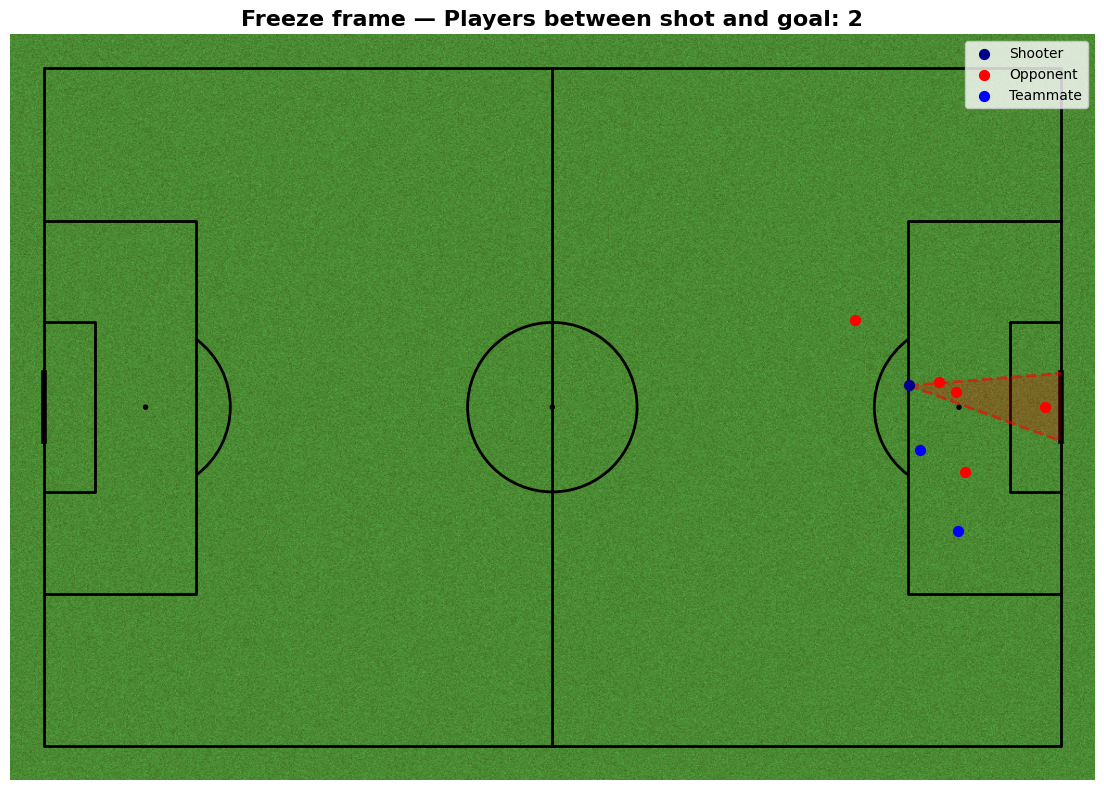

In [28]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

# Get a random shot from ds2
sample_row = ds2.sample(1).iloc[0]

# Shooter position (denormalized)
loc_x, loc_y = sample_row["loc_x"] * X_MAX, sample_row["loc_y"] * Y_MAX
ff = sample_row["shot_freeze_frame"]

# Calculate vectors to goalposts
vec_left = np.array([GOAL_X - loc_x, GOAL_Y_BOTTOM - loc_y])
vec_right = np.array([GOAL_X - loc_x, GOAL_Y_TOP - loc_y])

# Draw pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(12, 8))

# Draw shooting cone
cone = Polygon([[loc_x, loc_y],
                [GOAL_X, GOAL_Y_BOTTOM],
                [GOAL_X, GOAL_Y_TOP]],
               closed=True, facecolor='red', alpha=0.25)
ax.add_patch(cone)

# Shooter
pitch.scatter(loc_x, loc_y, ax=ax, c='darkblue', s=50, label='Shooter', zorder=3)

# Flags to avoid duplicate legend labels
teammate_plotted = False
opponent_plotted = False

# Players in freeze frame
for p in ff:
    px, py = p["location"]
    if p["teammate"]:
        pitch.scatter(px, py, ax=ax, c='blue', s=50, 
                      label='Teammate' if not teammate_plotted else "")
        teammate_plotted = True
    else:
        pitch.scatter(px, py, ax=ax, c='red', s=50, 
                      label='Opponent' if not opponent_plotted else "")
        opponent_plotted = True

# Cone boundaries
ax.plot([loc_x, GOAL_X], [loc_y, GOAL_Y_BOTTOM], 'r--', linewidth=2, alpha=0.6)
ax.plot([loc_x, GOAL_X], [loc_y, GOAL_Y_TOP], 'r--', linewidth=2, alpha=0.6)

# Title with computed value
ax.set_title(f"Freeze frame — Players between shot and goal: {sample_row['num_players_between']}", fontsize=16, fontweight='bold')

plt.legend()
plt.show()


### Distance to closest defender

This feature captures the **immediate defensive pressure** applied to the shooter by measuring the Euclidean distance from the shooting location to the closest opponent.  

The distance is computed as:  

$
d = \min_{p \in O} \sqrt{(x_p - x_s)^2 + (y_p - y_s)^2}
$

where $(x_s, y_s)$ is the shooter’s position and $O$ is the set of all opponent players in the freeze frame.


In [29]:
import numpy as np

# Constants for denormalization of loc_x and loc_y
X_MAX = 120
Y_MAX = 80

def closest_defender_distance(row):
    """Compute the distance to the closest opponent"""
    sx, sy = row["loc_x"] * X_MAX, row["loc_y"] * Y_MAX
    ff = row["shot_freeze_frame"]

    min_dist = np.inf
    for p in ff:
        if not p["teammate"]:  # only opponents
            px, py = p["location"]
            dist = np.sqrt((px - sx) ** 2 + (py - sy) ** 2)
            if dist < min_dist:
                min_dist = dist

    return min_dist if min_dist != np.inf else np.nan

# Apply to dataset
ds2["closest_defender_dist"] = ds2.apply(closest_defender_distance, axis=1)

# Quick check
print(ds2["closest_defender_dist"].describe())

count    86831.000000
mean         6.458865
std          4.744111
min          0.011148
25%          3.017317
50%          5.012555
75%          8.763685
max         90.958648
Name: closest_defender_dist, dtype: float64


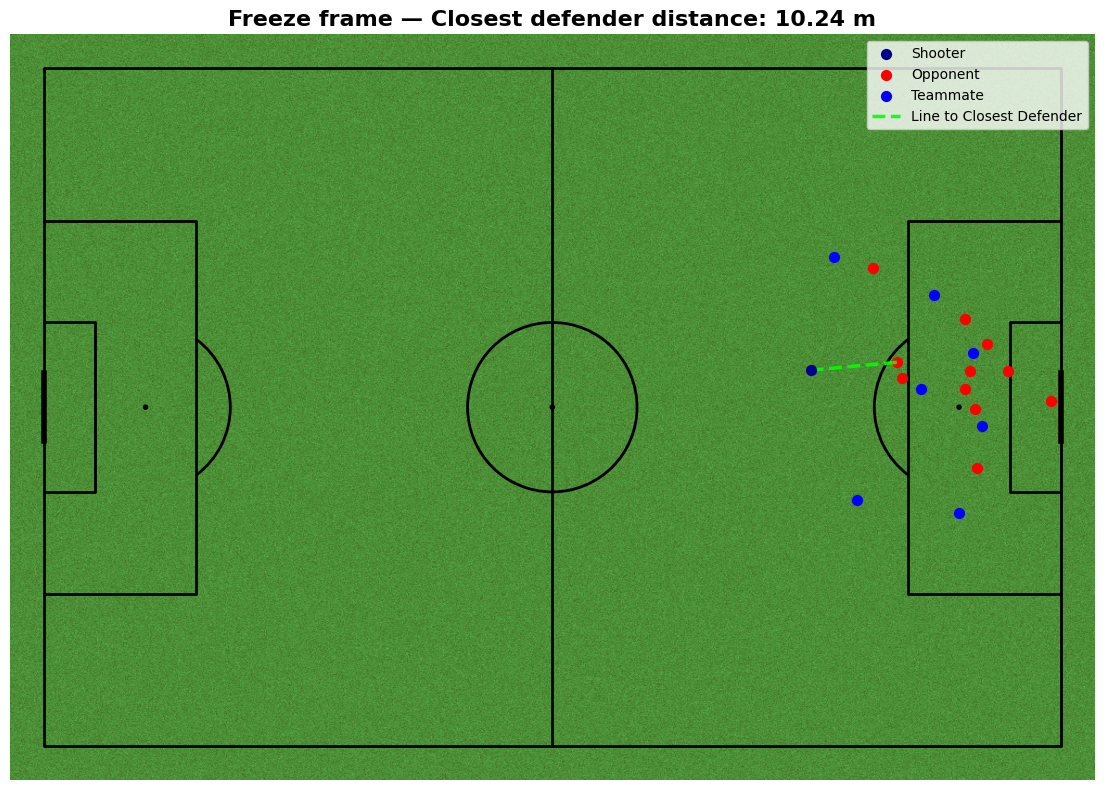

In [30]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

# Get a random shot from ds2
sample_row = ds2.sample(1).iloc[0]

# Shooter position (denormalized)
loc_x, loc_y = sample_row["loc_x"] * X_MAX, sample_row["loc_y"] * Y_MAX
ff = sample_row["shot_freeze_frame"]

# Use the precomputed column
min_dist = sample_row["closest_defender_dist"]

# Find actual closest defender location
closest_def = None
for p in ff:
    if not p["teammate"]:  # opponent
        px, py = p["location"]
        dist = np.sqrt((px - loc_x) ** 2 + (py - loc_y) ** 2)
        if abs(dist - min_dist) < 1e-6:
            closest_def = (px, py)
            break

# Draw pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(12, 8))

# Shooter
pitch.scatter(loc_x, loc_y, ax=ax, c='darkblue', s=50, label='Shooter', zorder=3)

# Flags to avoid duplicate legend labels
teammate_plotted = False
opponent_plotted = False

# Players in freeze frame
for p in ff:
    px, py = p["location"]
    if p["teammate"]:
        pitch.scatter(px, py, ax=ax, c='blue', s=50, 
                      label='Teammate' if not teammate_plotted else "")
        teammate_plotted = True
    else:
        pitch.scatter(px, py, ax=ax, c='red', s=50, 
                      label='Opponent' if not opponent_plotted else "")
        opponent_plotted = True

# Draw line to closest defender
if closest_def is not None:
    cx, cy = closest_def
    ax.plot([loc_x, cx], [loc_y, cy], color='lime', linewidth=2.5, alpha=0.9, label="Line to Closest Defender", linestyle='--')

# Title with computed value
ax.set_title(f"Freeze frame — Closest defender distance: {min_dist:.2f} m", 
             fontsize=16, fontweight='bold')

plt.legend()
plt.show()

### Goalkeeper positioning

For each shot, let's identify the **opponent goalkeeper** in the freeze frame and measure how well he is aligned with the direct shot line towards the center of the goal.  

- If the goalkeeper is perfectly aligned, the value is **0**.  
- The larger the value, the more the goalkeeper is **out of position** relative to the shot.  


In [31]:
import numpy as np

def goalkeeper_positioning(row):
    # Shooter position (denormalized)
    loc_x, loc_y = row["loc_x"] * X_MAX, row["loc_y"] * Y_MAX
    ff = row["shot_freeze_frame"]
    
    # Goal center
    gx, gy = GOAL_X, (GOAL_Y_TOP + GOAL_Y_BOTTOM) / 2
    
    # Find goalkeeper among opponents
    gk = None
    for p in ff:
        if (not p["teammate"]) and p["position"]["name"] == "Goalkeeper":
            gk = p["location"]
            break
    if gk is None:
        return np.nan
    
    kx, ky = gk
    
    # Perpendicular distance from goalkeeper to shot line (shooter → goal center)
    numerator = abs((gy - loc_y) * kx - (gx - loc_x) * ky + gx*loc_y - gy*loc_x)
    denominator = np.sqrt((gy - loc_y) ** 2 + (gx - loc_x) ** 2)
    d = numerator / denominator
    
    return d

# Apply to dataset
ds2["goalkeeper_positioning"] = ds2.apply(goalkeeper_positioning, axis=1)

# Show a preview
ds2[["goalkeeper_positioning"]].head()


goalkeeper_positioning
0                1.175386
1                1.639139
2                1.088339
3                0.759818
4                0.075680

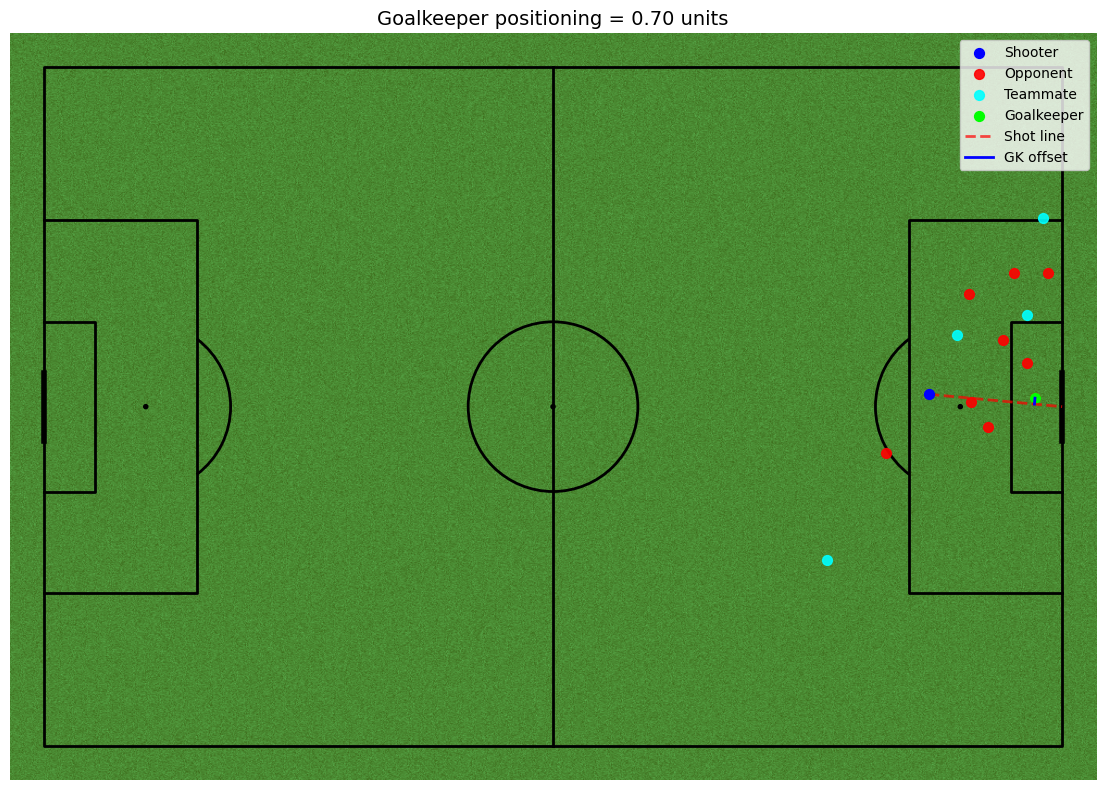

In [32]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

# Pick a random shot
sample_row = ds2.sample(1).iloc[0]

# Shooter position (denormalized)
loc_x, loc_y = sample_row["loc_x"] * X_MAX, sample_row["loc_y"] * Y_MAX
ff = sample_row["shot_freeze_frame"]

# Goal center
gx, gy = GOAL_X, (GOAL_Y_TOP + GOAL_Y_BOTTOM) / 2

# Get goalkeeper position
gk = None
for p in ff:
    if (not p["teammate"]) and p["position"]["name"] == "Goalkeeper":
        gk = p["location"]
        break

# Draw pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw(figsize=(12, 8))

# Shooter
pitch.scatter(loc_x, loc_y, ax=ax, c='blue', s=50, label="Shooter", zorder=3)

# Flags to avoid duplicate labels
teammate_plotted = False
opponent_plotted = False

# All players
for p in ff:
    px, py = p["location"]
    if p["teammate"]:
        pitch.scatter(px, py, ax=ax, c='cyan', s=50, alpha=0.9,
                      label="Teammate" if not teammate_plotted else "")
        teammate_plotted = True
    else:
        pitch.scatter(px, py, ax=ax, c='red', s=50, alpha=0.9,
                      label="Opponent" if not opponent_plotted else "")
        opponent_plotted = True

# Highlight goalkeeper
if gk is not None:
    kx, ky = gk
    pitch.scatter(kx, ky, ax=ax, c='lime', s=50, label="Goalkeeper")

    # Draw shot line (shooter → goal center)
    ax.plot([loc_x, gx], [loc_y, gy], 'r--', linewidth=2, alpha=0.7, label="Shot line")

    # Projection formula
    A = np.array([loc_x, loc_y])
    B = np.array([gx, gy])
    P = np.array([kx, ky])
    AB = B - A
    AP = P - A
    t = np.dot(AP, AB) / np.dot(AB, AB)
    proj = A + t * AB  # projection point

    ax.plot([kx, proj[0]], [ky, proj[1]], 'g-', color='blue', linewidth=2, alpha=1, label="GK offset")

    # Title with precomputed distance
    ax.set_title(f"Goalkeeper positioning = {sample_row['goalkeeper_positioning']:.2f} units",
                 fontsize=14)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right")

plt.show()


### Free projection of the goal

The **free projection of the goal** measures how much of the shooting cone (the angular width between the two goalposts as seen from the shooter) is still available after considering the goalkeeper's position.  

1. Compute the angles from the shooter to both goalposts to define the shooting cone as did in previous steps
2. Compute the angle from the shooter to the goalkeeper 
3. If the goalkeeper falls inside the cone, we assume they block a small angular section (approximate body width from shooter’s perspective).  
4. The **free angle** is the cone width minus the blocked angle.  
5. The **free ratio** is the percentage of goal still visible:  

$
\text{free\_ratio} = \frac{\text{free\_angle}}{\text{total\_cone\_angle}}
$

In [33]:
import numpy as np

def compute_free_projection(row):

    loc_x, loc_y = row["loc_x"] * X_MAX, row["loc_y"] * Y_MAX
    ff = row["shot_freeze_frame"]

    # Find goalkeeper
    gk = None
    for p in ff:
        if (not p["teammate"]) and p["position"]["name"] == "Goalkeeper":
            gk = p["location"]
            break

    if gk is None:
        return np.nan  # no goalkeeper found

    gk_x, gk_y = gk

    # Goal posts
    left_post = np.array([GOAL_X, GOAL_Y_BOTTOM])
    right_post = np.array([GOAL_X, GOAL_Y_TOP])
    shooter = np.array([loc_x, loc_y])
    gk = np.array([gk_x, gk_y])

    # Vectors
    vec_left = left_post - shooter
    vec_right = right_post - shooter
    vec_gk = gk - shooter

    # Angles
    ang_left = np.arctan2(vec_left[1], vec_left[0])     # angle between shooter and left post
    ang_right = np.arctan2(vec_right[1], vec_right[0])  # angle between shooter and right post
    ang_gk = np.arctan2(vec_gk[1], vec_gk[0])           # angle between GK and shooter

    # Normalize so ang_left < ang_right
    if ang_left > ang_right:
        ang_left, ang_right = ang_right, ang_left

    total_width = ang_right - ang_left

    # Assume GK blocks 0.13 rad (~7.5°)
    blocked = 0
    if ang_left <= ang_gk <= ang_right:
        blocked = min(total_width, 0.13)

    free_angle = max(0, total_width - blocked)
    free_ratio = free_angle / total_width if total_width > 0 else 0

    return free_ratio

# Apply to dataset
ds2["free_proj_goal"] = ds2.apply(compute_free_projection, axis=1)

# Show a preview
ds2[["free_proj_goal"]].head()

free_proj_goal
0        0.547530
1        0.786364
2        0.482921
3        0.764571
4        0.319861

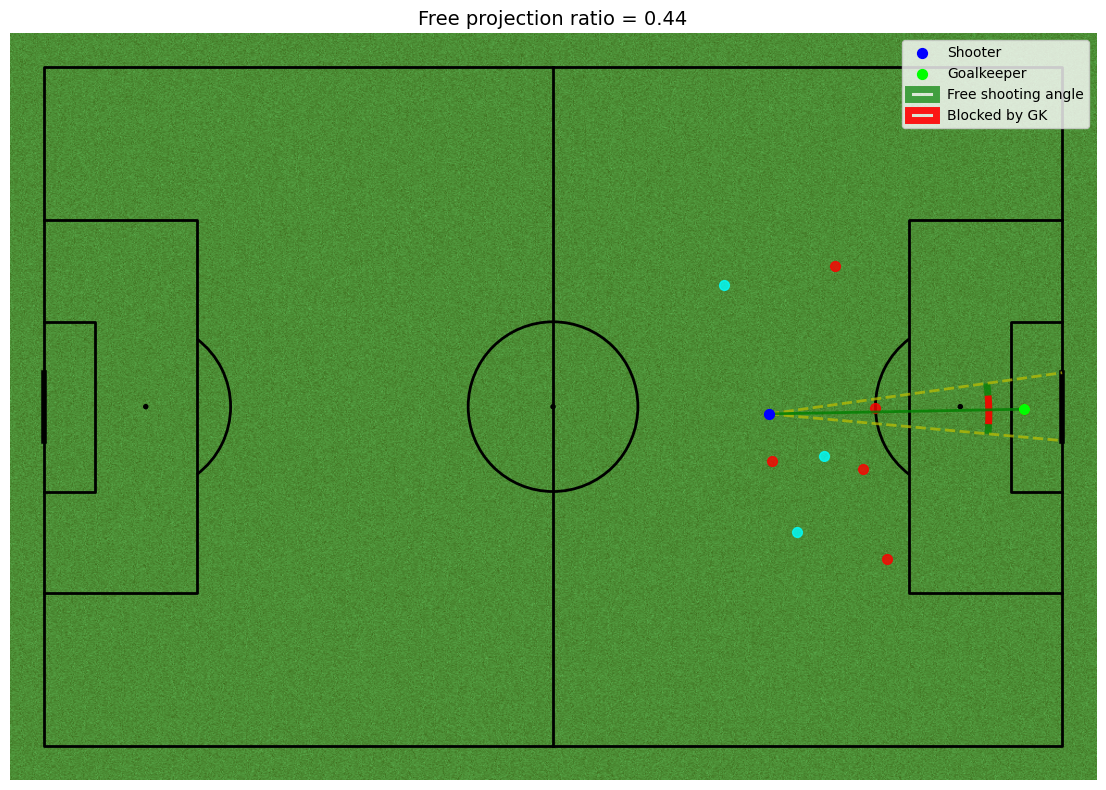

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from mplsoccer import Pitch

# Select a random shot and compute the free_ratio
row = ds2.sample(1).iloc[0]
free_ratio = compute_free_projection(row)

# Extract shooter and freeze frame
loc_x, loc_y = row["loc_x"] * X_MAX, row["loc_y"] * Y_MAX
ff = row["shot_freeze_frame"]

# Find goalkeeper
gk = None
for p in ff:
    if (not p["teammate"]) and p["position"]["name"] == "Goalkeeper":
        gk = p["location"]
        break
if gk is None:
    print("No goalkeeper found for this shot")
else:
    gk_x, gk_y = gk

    # Goal posts
    left_post = np.array([GOAL_X, GOAL_Y_BOTTOM])
    right_post = np.array([GOAL_X, GOAL_Y_TOP])
    shooter = np.array([loc_x, loc_y])
    gk = np.array([gk_x, gk_y])

    # Vectors
    vec_left = left_post - shooter
    vec_right = right_post - shooter
    vec_gk = gk - shooter

    # Angles
    ang_left = np.arctan2(vec_left[1], vec_left[0])     # angle between shooter and left post
    ang_right = np.arctan2(vec_right[1], vec_right[0])  # angle between shooter and right post
    ang_gk = np.arctan2(vec_gk[1], vec_gk[0])           # angle between GK and shooter

    if ang_left > ang_right:
        ang_left, ang_right = ang_right, ang_left

    # Plot
    pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
    fig, ax = pitch.draw(figsize=(12, 8))

    # Shooter
    pitch.scatter(loc_x, loc_y, ax=ax, c='blue', s=50, label="Shooter", zorder=3)

    # Other players
    for p in ff:
        px, py = p["location"]
        color = 'cyan' if p["teammate"] else 'red'
        pitch.scatter(px, py, ax=ax, c=color, s=50, alpha=0.8)
    pitch.scatter(gk_x, gk_y, ax=ax, c='lime', s=50, label="Goalkeeper", zorder=4)

    # Shooting cone lines
    ax.plot([loc_x, left_post[0]], [loc_y, left_post[1]], 'y--', lw=2, alpha=0.7)
    ax.plot([loc_x, right_post[0]], [loc_y, right_post[1]], 'y--', lw=2, alpha=0.7)

    # GK line
    ax.plot([loc_x, gk_x], [loc_y, gk_y], 'g-', lw=2, alpha=0.8)

    # Arcs aligned with the real cone

    r = abs(GOAL_X - loc_x)            # Distance from shooter to goal line to be used for arc radius

    start_angle = np.degrees(ang_left)
    end_angle = np.degrees(ang_right)

    # Arc for free shooting angle
    arc_free = Arc((loc_x, loc_y), 1.5*r, 1.5*r, angle=0,
                   theta1=start_angle, theta2=end_angle,
                   color="green", lw=5, alpha=0.7, label="Free shooting angle")
    ax.add_patch(arc_free)

    # GK blocks ~0.13 rad
    blocked = 0.13
    if ang_left <= ang_gk <= ang_right:
        start_block = np.degrees(ang_gk - blocked/2)
        end_block = np.degrees(ang_gk + blocked/2)
        arc_block = Arc((loc_x, loc_y), 1.5*r, 1.5*r, angle=0,
                        theta1=start_block, theta2=end_block,
                        color="red", lw=5, alpha=0.9, label="Blocked by GK")
        ax.add_patch(arc_block)

    ax.set_title(f"Free projection ratio = {free_ratio:.2f}", fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.show()


### Normalization of the new variables

In [35]:
# Feature summary check
features_to_check = [
    "num_players_between",      
    "closest_defender_dist",    
    "goalkeeper_positioning",             
    "free_proj_goal"           
]

for feat in features_to_check:
    if feat not in ds2.columns:
        print(f"Feature {feat} not found in dataset")
        continue

    print(f"\n--- {feat} ---")
    print("Type:", ds2[feat].dtype)
    print("Min:", ds2[feat].min())
    print("Max:", ds2[feat].max())
    print("Mean:", ds2[feat].mean())


--- num_players_between ---
Type: int64
Min: 0
Max: 14
Mean: 2.503034560593323

--- closest_defender_dist ---
Type: float64
Min: 0.011147564936853094
Max: 90.95864806041433
Mean: 6.4588653982992

--- goalkeeper_positioning ---
Type: float64
Min: 0.0
Max: 54.080944741952706
Mean: 0.9305049075056541

--- free_proj_goal ---
Type: float64
Min: 0.0
Max: 1.0
Mean: 0.5628431239274488


In [36]:
from sklearn.preprocessing import MinMaxScaler

features_to_normalize = [   
    "closest_defender_dist",    
    "goalkeeper_positioning",                   
]

scaler = MinMaxScaler()
ds2[features_to_normalize] = scaler.fit_transform(ds2[features_to_normalize])

for feat in features_to_normalize:
    if feat not in ds2.columns:
        print(f"Feature {feat} not found in dataset")
        continue

    print(f"\n--- {feat} ---")
    print("Type:", ds2[feat].dtype)
    print("Min:", ds2[feat].min())
    print("Max:", ds2[feat].max())
    print("Mean:", ds2[feat].mean())


--- closest_defender_dist ---
Type: float64
Min: 0.0
Max: 0.9999999999999999
Mean: 0.07089494266731357

--- goalkeeper_positioning ---
Type: float64
Min: 0.0
Max: 1.0
Mean: 0.01720578129589932


### Final Step – Save the DS2 Dataset

The final dataset is then saved as `DS2.csv` to ensure reproducibility and easy access for model training.


In [37]:
# Final checks
ds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86833 entries, 0 to 86832
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   event_id                   86833 non-null  object 
 1   match_id                   86833 non-null  int64  
 2   team_id                    86833 non-null  int64  
 3   player_id                  86833 non-null  float64
 4   possession_team_id         86833 non-null  int64  
 5   minute                     86833 non-null  float64
 6   second                     86833 non-null  float64
 7   under_pressure             86833 non-null  bool   
 8   shot_first_time            86833 non-null  bool   
 9   shot_one_on_one            86833 non-null  bool   
 10  target_xg                  86833 non-null  float64
 11  loc_x                      86833 non-null  float64
 12  loc_y                      86833 non-null  float64
 13  end_shot_x                 86833 non-null  flo

In [38]:
# Drop unnecessary columns
ds2.drop(columns=["shot_freeze_frame"], inplace=True)

ds2.columns

Index(['event_id', 'match_id', 'team_id', 'player_id', 'possession_team_id',
       'minute', 'second', 'under_pressure', 'shot_first_time',
       'shot_one_on_one', 'target_xg', 'loc_x', 'loc_y', 'end_shot_x',
       'end_shot_y', 'shot_technique_Normal', 'shot_body_part_Head',
       'shot_body_part_Left_Foot', 'shot_body_part_Other',
       'shot_body_part_Right_Foot', 'shot_from_set_piece',
       'shot_technique_Aerial', 'shot_technique_Special', 'distance_to_goal',
       'angle_to_goal', 'regular_Time', 'extra_Time', 'penalty_Shootout',
       'play_context_Regular_Play', 'play_context_Counter',
       'play_context_Set_Piece', 'gender_binary', 'role_DEF', 'role_FWD',
       'role_GK', 'role_MID', 'num_players_between', 'closest_defender_dist',
       'goalkeeper_positioning', 'free_proj_goal'],
      dtype='object')

In [39]:
# Save DS1 to disk
ds1.to_csv("../task1_xg/data/DS1.csv", index=False)

# Save DS2 to disk
ds2.to_csv("../task1_xg/data/DS2.csv", index=False)

## DS3: Only male and no penalty

# IDEE PER FUTURE IMPLEMENTAZIONI:

- LSTM CON ANALISI DI INTERE PARTITE
- AGGIUNTA DI EVENTI PRECEDENTI PER STUDIARE COME E' ARRIVATA LA PALLA AL TIRATORE
- UTILIZZARE GRAPH ANALYSIS O IMAGE DETECTION PER STUDIARE I FREEZE FRAMES E DARLI A UN TRANSFORMER AD ESEMPIO